# Fine-Tunning of InceptionV3 network for Alzheimer Diagnosis

In this notebook, we are going to import a Keras InceptionV3 network, pre-trained on ImageNet, and perform fine-tunning for the task of Alzheimer Diagnosis. We already have a TFRecords database with 2D images.



Then, we have to import all the libraries that we are going to need:

In [0]:
import tensorflow as tf
import numpy as np

from tensorflow import keras
from skimage import filters
from matplotlib import pyplot as plt
from sklearn import metrics as skmetrics
from scipy import interp
from itertools import cycle

import os
import collections
import json

Specify the path to the TFRecords files, as well as the names of the files.

In [0]:
# 2D supervised TFRecords databases
DB_TF_2D_PATH ='/content/drive/MyDrive/TF_RECORDS/TF_RECORDS_2D/'

# training files

TFREC_2D_SS_TRAIN = 'train.2D.skull_stripped.tfrecords'
TFREC_2D_BIN_TRAIN = 'train.2D.binary.tfrecords'

# validation files

TFREC_2D_SS_VAL = 'validation.2D.skull_stripped.tfrecords'
TFREC_2D_BIN_VAL = 'validation.2D.binary.tfrecords'

# test files

TFREC_2D_SS_TEST = 'test.2D.skull_stripped.tfrecords'
TFREC_2D_BIN_TEST = 'test.2D.binary.tfrecords'

In [0]:
DB_MODELS = '/content/drive/MyDrive/MODELS/fine_tuned_inception_v3'

Also, create constants with the shape of the images and a dictionary with the class labels.

In [0]:
LABELS = {'CN': 0, 'MCI': 1, 'AD': 2}
BINARY_LABELS = {'CN': 0, 'AD': 1}

ORIGINAL_IMG_SHAPE = (78, 110, 86)
IMG_2D_SHAPE = (ORIGINAL_IMG_SHAPE[1] * 4, 
                ORIGINAL_IMG_SHAPE[2] * 4, 
                1)
IMG_RGB_SHAPE = (ORIGINAL_IMG_SHAPE[1] * 4, 
                 ORIGINAL_IMG_SHAPE[2] * 4, 
                 3)

TEST_SPLIT = 0.15
VALIDATION_SPLIT = 0.15

In [0]:
def plot_training(history, title):
  ''' Plot the training and validation loss + accuracy
  '''
  
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.figure(figsize=(20, 8))

  plt.subplot(121)
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.legend(('Training accuracy', 'Validation accuracy'),
             loc='upper right')
  plt.title(title + '- Accuracy')

  plt.subplot(122)
  plt.plot(epochs, loss, 'b.')
  plt.plot(epochs, val_loss, 'b')
  plt.legend(('Training loss', 'Validation loss'),
             loc='upper right')
  plt.title(title + '- Loss')
  
  export_file = '-'.join(title.split()) + '.png'
  plt.savefig(os.path.join(DB_MODELS, export_file))
  
  plt.show()

---

### Checking TFRecords data


In [0]:
training_tfrec = os.path.join(DB_TF_2D_PATH, TFREC_2D_BIN_TRAIN)
validation_tfrec = os.path.join(DB_TF_2D_PATH, TFREC_2D_BIN_VAL)
test_tfrec = os.path.join(DB_TF_2D_PATH, TFREC_2D_BIN_TEST)

In [0]:
n_training_samples = 1658
n_val_samples = 292
n_test_samples = 344
total_n_samples = n_training_samples + n_val_samples + n_test_samples

---

### Importing TFRecords

In [0]:
SHUFFLE_BUFFER = 100

In [0]:
def decode(serialized_example):
  
  # decode examples stored in TFRecord
  feature = tf.parse_single_example(
      serialized_example,
      features = {
          'image': tf.FixedLenFeature(IMG_RGB_SHAPE, tf.float32),
          'label': tf.FixedLenFeature([], tf.int64)
      }
  )
  
  return feature['image'], feature['label']

In [0]:
def dataset_parser(filepath, batch_size, n_classes, use_undersampling=False):
  ''' This method is a pipeline for feeding
      tfrecord data into a Keras model.
      
      Parameters:
        filepath -- The complete path to the TFRecord file
        batch_size
        n_classes 
        
      Returns:
        image -- Tensor with the image
        label -- Tensor with the label
  '''
  
  # create and configure the dataset
  dataset = tf.data.TFRecordDataset(filepath).map(decode)
  dataset = dataset.shuffle(SHUFFLE_BUFFER, seed=tf.random.set_random_seed(21))
  dataset = dataset.repeat()
  
  if use_undersampling:
    resampler = tf.data.experimental.rejection_resample(
        class_func=lambda _, label: label,
        target_dist=[0.3, 0.4, 0.3])
        # maybe we'll need to use initial_dist
    dataset = dataset.apply(resampler)
      
    # return to the same dataset shape as was the original
    # using rejection resamples changes that
    dataset = dataset.map(lambda _, data: (data))
  
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  
  # get example
  iterator = dataset.make_one_shot_iterator()
  image, label = iterator.get_next()
  
  # encode the label
  label = tf.one_hot(label, n_classes)
  # give the image three channels
  #image = tf.image.grayscale_to_rgb(image)
  
  return image, label

In [0]:
def get_n_samples(tfrec, decoding_fn):
  '''
  '''
  
  # create the iterator for the TFRecord
  dataset = tf.data.TFRecordDataset(tfrec).map(decoding_fn)
  dataset = dataset.map(lambda img, label: (tf.image.grayscale_to_rgb(img), label))
  
  '''resampler = tf.data.experimental.rejection_resample(
        class_func=lambda _, label: label,
        target_dist=[0.3, 0.4, 0.3])
  
  dataset = dataset.apply(resampler)'''
      
  # return to the same dataset shape as was the original
  # using rejection resamples changes that
  dataset = dataset.map(lambda _, data: (data))
  
  iterator = dataset.make_one_shot_iterator()
  next_record = iterator.get_next()

  # init a session, copying the information to the placeholders
  n_samples = 0
  with tf.Session() as sess:
    try:
      while True:
        sess.run(next_record)
        n_samples += 1
    except:
      pass
      
  return n_samples

---
### Model building


In [0]:
UNDERSAMPLING = False
BATCH_SIZE = 8

if UNDERSAMPLING:
  n_training_samples = get_n_samples(training_tfrec, decode)
  n_val_samples = get_n_samples(validation_tfrec, decode)
  
STEPS_PER_EPOCH = int(n_training_samples / BATCH_SIZE)
VALIDATION_STEPS = int(n_val_samples / BATCH_SIZE)

n_classes = len(BINARY_LABELS)

In [0]:
image_tensor, label_tensor = dataset_parser(training_tfrec, 
                                            BATCH_SIZE, 
                                            n_classes, 
                                            use_undersampling=UNDERSAMPLING)

In [0]:
base_model = tf.keras.applications.inception_v3.InceptionV3(
    input_shape=(IMG_2D_SHAPE[0], IMG_2D_SHAPE[1], 3), 
    weights='imagenet', 
    include_top=False,
    pooling='max')

In [0]:
base_output = base_model.output
hidden_layer = tf.keras.layers.Dense(512, activation='relu')(base_output)
hl_reg = tf.keras.layers.Dropout(0.8)(hidden_layer)
output_layer = tf.keras.layers.Dense(n_classes, activation='softmax')(hl_reg)

model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

W0628 10:48:32.772597 140378777569152 nn_ops.py:4224] Large dropout rate: 0.8 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


---

### Training stage 1

Train the top fully connected layer.

In [0]:
# load validation data tensors
val_img_tensor, val_label_tensor = dataset_parser(validation_tfrec, 
                                                  BATCH_SIZE, 
                                                  n_classes)

In [0]:
fc_training = model.fit(x=image_tensor, y=label_tensor,
                        epochs=10, steps_per_epoch=STEPS_PER_EPOCH, 
                        validation_data=(val_img_tensor, val_label_tensor),
                        validation_steps=VALIDATION_STEPS)

Epoch 1/10
139/139 [==============================] - 33s 238ms/step - loss: 2.6013 - acc: 0.5108 - val_loss: 0.8857 - val_acc: 0.5260
Epoch 2/10
139/139 [==============================] - 26s 186ms/step - loss: 0.9569 - acc: 0.5522 - val_loss: 0.7596 - val_acc: 0.5417
Epoch 3/10
139/139 [==============================] - 26s 186ms/step - loss: 0.7359 - acc: 0.5585 - val_loss: 0.7399 - val_acc: 0.5104
Epoch 4/10
139/139 [==============================] - 26s 185ms/step - loss: 0.7056 - acc: 0.5809 - val_loss: 0.7521 - val_acc: 0.5260
Epoch 5/10
139/139 [==============================] - 26s 186ms/step - loss: 0.6936 - acc: 0.5674 - val_loss: 0.7187 - val_acc: 0.5573
Epoch 6/10
139/139 [==============================] - 26s 186ms/step - loss: 0.6805 - acc: 0.5647 - val_loss: 0.7696 - val_acc: 0.5260
Epoch 7/10
139/139 [==============================] - 26s 186ms/step - loss: 0.6897 - acc: 0.5818 - val_loss: 0.7252 - val_acc: 0.5260
Epoch 8/10
139/139 [==============================] - 2

---

### Saving and loading

Save the model at this point:

In [0]:
CHECKPOINT_STAGE_1 = 'fine_tuned_inception_v3_fc_trained'
model_file = os.path.join(DB_MODELS, CHECKPOINT_STAGE_1) + '.h5'

In [0]:
model.save(model_file) 

For loading, run the following cell:

In [0]:
model = tf.keras.models.load_model(model_file)

---

### Fine-tunning convolutions

In [0]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
#for layer in model.layers[:249]:
#  layer.trainable = False
for layer in model.layers:
  layer.trainable = True

optimizer = tf.keras.optimizers.Adam(lr=0.0001, decay=1e-6)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', 
              metrics=['acc'])

In [0]:
fine_tunning_history = model.fit(x=image_tensor, y=label_tensor,
                                 epochs=20, steps_per_epoch=STEPS_PER_EPOCH, 
                                 validation_data=(val_img_tensor, val_label_tensor),
                                 validation_steps=VALIDATION_STEPS)

Epoch 1/20
139/139 [==============================] - 95s 687ms/step - loss: 0.7205 - acc: 0.5647 - val_loss: 0.7729 - val_acc: 0.5469
Epoch 2/20
139/139 [==============================] - 82s 588ms/step - loss: 0.6964 - acc: 0.5809 - val_loss: 0.6788 - val_acc: 0.5781
Epoch 3/20
139/139 [==============================] - 82s 588ms/step - loss: 0.6825 - acc: 0.5917 - val_loss: 0.6821 - val_acc: 0.5573
Epoch 4/20
139/139 [==============================] - 82s 588ms/step - loss: 0.6994 - acc: 0.5944 - val_loss: 0.6864 - val_acc: 0.5208
Epoch 5/20
139/139 [==============================] - 82s 588ms/step - loss: 0.6579 - acc: 0.6259 - val_loss: 0.9557 - val_acc: 0.5781
Epoch 6/20
139/139 [==============================] - 82s 588ms/step - loss: 0.7303 - acc: 0.5899 - val_loss: 0.7918 - val_acc: 0.5625
Epoch 7/20
139/139 [==============================] - 82s 588ms/step - loss: 0.6236 - acc: 0.6223 - val_loss: 0.9863 - val_acc: 0.5469
Epoch 8/20
139/139 [==============================] - 8

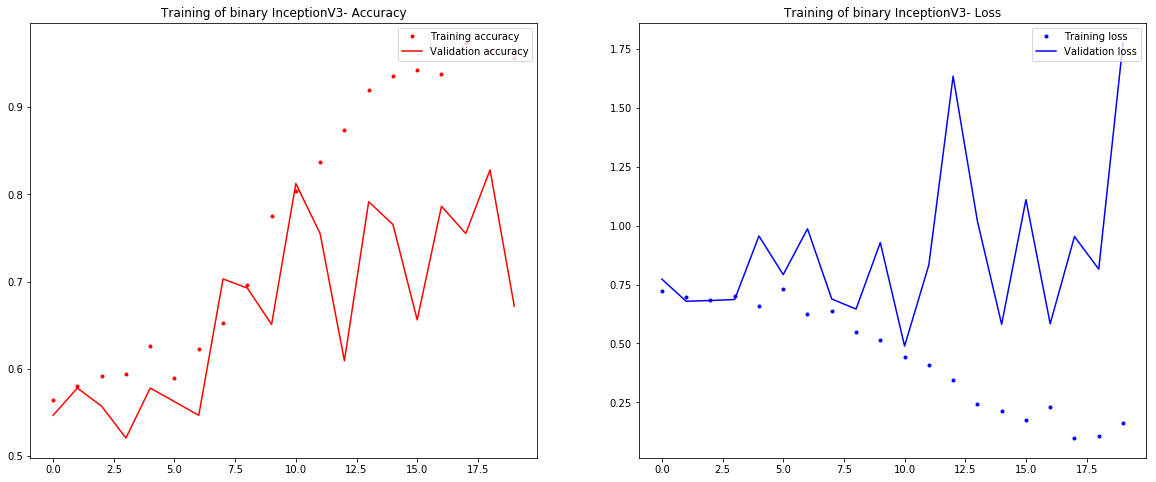

In [0]:
plot_training(fine_tunning_history, 'Training of binary InceptionV3')

---

### Saving and loading

Save the model at this point:

In [0]:
CHECKPOINT_STAGE_2 = 'fine_tuned_inception_v3'
model_file = os.path.join(DB_MODELS, CHECKPOINT_STAGE_2) + '.h5'

In [0]:
model_file = os.path.join(DB_MODELS, CHECKPOINT_STAGE_2) + '.h5'
model.save(model_file) 

For loading, run the following cell:

In [0]:
model = tf.keras.models.load_model(model_file)

---

### Testing

In [0]:
def get_data_for_predict(tfrec_file, decoding_fn):
  ''' Read and return the data from a TFRecord file.
      
      Params:
        tfrec_file -- Absolute path to the .tfrecord
        decoding_fn - Function used to decode the serialized examples
      
      Returns:
        images and labels (tuple)
  '''
  
  # create the placeholders
  images = np.empty((n_test_samples, *IMG_RGB_SHAPE))
  labels = np.empty((n_test_samples))

  # create the iterator for the TFRecord
  dataset = tf.data.TFRecordDataset(tfrec_file).map(decoding_fn)
  #dataset = dataset.map(lambda img, label: (tf.image.grayscale_to_rgb(img), label))
  iterator = dataset.make_one_shot_iterator()
  next_record = iterator.get_next()

  # init a session, copying the information to the placeholders
  i = 0
  with tf.Session() as sess:
    while i < n_test_samples:
      images[i,], labels[i] = sess.run(next_record)
      i += 1
      
  return images, labels

In [0]:
def compute_auc(model, images, labels, target_names, title):
  ''' Computes the ROC and AUC for a given model
      and a specific test set.
      
      Parameters:
        model -- The trained model
        images -- Images of the test set
        labels -- Labels for the images
        target_names -- Names for the labels
  '''
  n_classes = len(target_names)
  y_true = tf.keras.utils.to_categorical(labels, n_classes)
  y_pred = model.predict(x=images)
  
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = skmetrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = skmetrics.auc(fpr[i], tpr[i])
  
  # compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = skmetrics.roc_curve(y_true.ravel(), y_pred.ravel())
  roc_auc['micro'] = skmetrics.auc(fpr['micro'], tpr['micro'])
  
  # compute macro-average ROC curve and ROC area
  # first aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = skmetrics.auc(fpr['macro'], tpr['macro'])

  # plot all ROC curves
  plt.figure(figsize=(10, 10))
  plt.plot(fpr['micro'], tpr['micro'],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['micro']),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr['macro'], tpr['macro'],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(target_names[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  
  export_file = '-'.join(title.split()) + '.png'
  plt.savefig(os.path.join(DB_MODELS, export_file))
  
  plt.show()

In [0]:
def classification_report(model, images, labels, target_names, output_file):
  ''' Prints the classification report for a given model and
      a specific test set.
      
      Parameters:
        model -- The trained model
        images -- Images of the test set
        labels -- Labels of the images
        target_names -- Names of the labels
        output_file
  '''
  
  n_classes = len(target_names)
  y_true = tf.keras.utils.to_categorical(labels, n_classes)
  predictions = model.predict(x=images)
  
  output = skmetrics.classification_report(labels, predictions.argmax(axis=1), 
                                           target_names=target_names, output_dict=True)
  print(json.dumps(output, indent=4))
  
  with open(os.path.join(DB_MODELS, output_file), 'w') as output_json:
    json.dump(output, output_json, indent=4)

In [0]:
images, labels = get_data_for_predict(test_tfrec, decode)

In [0]:
classification_report(model, images, labels, BINARY_LABELS, 'classification-report-binary-model.json')

{
    "CN": {
        "precision": 0.671957671957672,
        "recall": 0.9621212121212122,
        "f1-score": 0.7912772585669783,
        "support": 132
    },
    "AD": {
        "precision": 0.8780487804878049,
        "recall": 0.3673469387755102,
        "f1-score": 0.5179856115107914,
        "support": 98
    },
    "accuracy": 0.7086956521739131,
    "macro avg": {
        "precision": 0.7750032262227384,
        "recall": 0.6647340754483612,
        "f1-score": 0.6546314350388849,
        "support": 230
    },
    "weighted avg": {
        "precision": 0.7597704051574677,
        "recall": 0.7086956521739131,
        "f1-score": 0.6748312524299943,
        "support": 230
    }
}


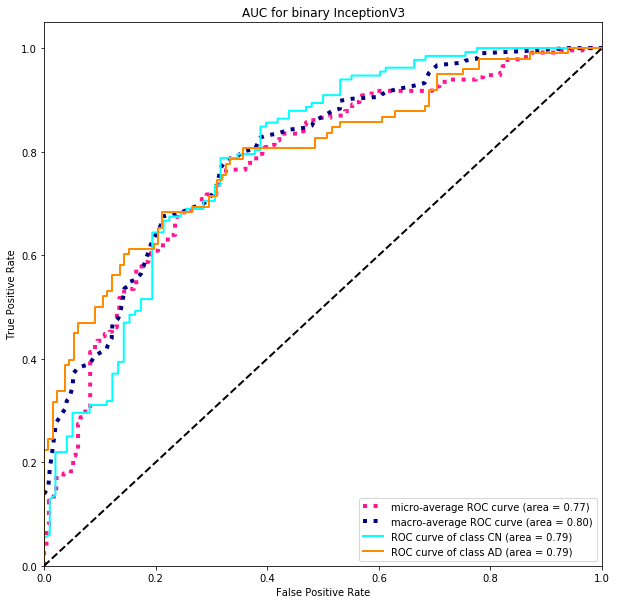

In [0]:
compute_auc(model, images, labels, ['CN', 'AD'], 'AUC for binary InceptionV3')